In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import random
import cv2
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers



np.random.seed(0)


In [2]:
# Load data into dataframe
training_data_folder = 'json_gender_data'
data = []

for folder in sorted(os.listdir(training_data_folder)):
    if folder[0] == '.':
        continue
    sub_folder = os.path.join(training_data_folder,folder)
    files = [{'label':folder,'path':os.path.join(sub_folder, f)} for f in os.listdir(sub_folder) if os.path.isfile(os.path.join(sub_folder, f))]
    data += files

df = pd.DataFrame(data)

map_characters = {0: 'M', 1: 'W'}

order_list = ['M', 'W']

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
hotEncodedLabels = lb.fit_transform(order_list)
hotEncodedLabels

#This code will only load the folders for 'M' (man) and 'W' (woman) from the training data folder, and label the data as either "man" or "woman".
#The hot encoded labels will also be changed to [1,0] for "man" and [0,1] for "woman".


array([[0],
       [1]])

In [8]:
train_dir = 'json_gender_data'

map_characters = {0: 'M', 1: 'W'}

labels_dict = {'M': 0, 'W': 1}

order_list = ('M', 'W')

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 29,400
    num=0

    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir): ## to check 
        if folder[0] == '.':
            continue
        print(folder, end = ' | ')
        for json_file in os.listdir(train_dir + "/" + folder):
            temp_json_file = json.load(open(train_dir + '/' + folder + '/' + json_file))
            temp_np_array = np.array(temp_json_file)
            temp = [cv2.resize(temp_np_array[0], size)]
            temp_img = np.array(temp)
            # plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
            # plt.show()
            images.append(temp_img)
            labels.append(num)
        num+=1
    
    
    images = np.array(images)
    # images = images.astype('float32')/255
    
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.3, random_state=42)
    X_test, X_validation, Y_test, Y_validation = train_test_split(X_test, Y_test, test_size = 0.8,random_state=42)
    
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_validation),'images for validation','validation data shape =',X_validation.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    print('\n')

    
    return X_train, X_test, Y_train, Y_test, X_validation, Y_validation

In [9]:
X_train, X_test, Y_train, Y_test, X_validation, Y_validation= load_data()

LOADING DATA FROM : M | W | 
Loaded 693 images for training, Train data shape = (693, 1, 400, 29)
Loaded 238 images for validation validation data shape = (238, 1, 400, 29)
Loaded 59 images for testing Test data shape = (59, 1, 400, 29)




In [12]:

DROP_OUT = 0.5
NUM_OF_SPEAKERS = 2

with tf.device('/CPU:0'):
    model = keras.models.Sequential()
   
    model.add(layers.Conv2D(96, (7,7), strides=(2,2), padding="same", activation='relu', input_shape=(1,400,29)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

    model.add(layers.Conv2D(256, (5,5), strides=(2,2), padding="same", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((3,3), strides=(2,2), padding="same"))

    model.add(layers.Conv2D(384, (3,3), strides=(1,1), padding="same", activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3,3), strides=(1,1), padding="same", activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3,3), strides=(1,1), padding="same", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D((5,3), strides=(3,2), padding="same"))

    model.add(layers.Conv2D(4096, (9,1), strides=(1,1), padding="same", activation='relu'))
    model.add(layers.Dropout(rate=DROP_OUT))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(rate=DROP_OUT))

    model.add(layers.Dense(NUM_OF_SPEAKERS))
    
    print(model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 1, 200, 96)        136512    
                                                                 
 batch_normalization_15 (Bat  (None, 1, 200, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 100, 96)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 1, 50, 256)        614656    
                                                                 
 batch_normalization_16 (Bat  (None, 1, 50, 256)       1024      
 chNormalization)                                                
                                                      

In [13]:
with tf.device('/CPU:0'):
    # loss and optimizer
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optim = keras.optimizers.Adam(lr=0.001)
    metrics = ["accuracy"]
    model.compile(optimizer=optim, loss=loss, metrics=metrics)


In [14]:
with tf.device('/CPU:0'):
    data_x=np.array(X_train)
    data_y=np.array(Y_train)

    val_x=np.array(X_validation)
    val_y=np.array(Y_validation)

    # training
    batch_size = 10
    epochs = 15
    model.fit(data_x, data_y, epochs=epochs, batch_size=batch_size, verbose=2)
    print("eval")
    model.evaluate(val_x,  val_y, batch_size=batch_size, verbose=2)
    
    epochs = 15
    optim = keras.optimizers.Adam(lr=0.0001)
    model.fit(data_x, data_y, epochs=epochs, batch_size=batch_size, verbose=2)
    print("eval")
    model.evaluate(val_x,  val_y, batch_size=batch_size, verbose=2)

    # evaulate

Epoch 1/15
70/70 - 42s - loss: 0.7093 - accuracy: 0.7056 - 42s/epoch - 606ms/step
Epoch 2/15
70/70 - 39s - loss: 0.5454 - accuracy: 0.7518 - 39s/epoch - 555ms/step
Epoch 3/15
70/70 - 39s - loss: 0.4017 - accuracy: 0.8341 - 39s/epoch - 552ms/step
Epoch 4/15
70/70 - 38s - loss: 0.3672 - accuracy: 0.8586 - 38s/epoch - 549ms/step
Epoch 5/15
70/70 - 38s - loss: 0.3444 - accuracy: 0.8470 - 38s/epoch - 548ms/step
Epoch 6/15
70/70 - 38s - loss: 0.2547 - accuracy: 0.8975 - 38s/epoch - 544ms/step
Epoch 7/15
70/70 - 39s - loss: 0.2861 - accuracy: 0.8990 - 39s/epoch - 552ms/step
Epoch 8/15
70/70 - 39s - loss: 0.3004 - accuracy: 0.8860 - 39s/epoch - 553ms/step
Epoch 9/15
70/70 - 39s - loss: 0.1951 - accuracy: 0.9235 - 39s/epoch - 551ms/step
Epoch 10/15
70/70 - 38s - loss: 0.2308 - accuracy: 0.9206 - 38s/epoch - 546ms/step
Epoch 11/15
70/70 - 38s - loss: 0.1629 - accuracy: 0.9365 - 38s/epoch - 543ms/step
Epoch 12/15
70/70 - 38s - loss: 0.1577 - accuracy: 0.9452 - 38s/epoch - 547ms/step
Epoch 13/15
7

Epoch 1/15
70/70 - 38s - loss: 0.2209 - accuracy: 0.9177 - 38s/epoch - 545ms/step
Epoch 2/15
70/70 - 38s - loss: 0.1828 - accuracy: 0.9452 - 38s/epoch - 546ms/step
Epoch 3/15
70/70 - 39s - loss: 0.1365 - accuracy: 0.9481 - 39s/epoch - 551ms/step
Epoch 4/15
70/70 - 39s - loss: 0.0718 - accuracy: 0.9755 - 39s/epoch - 551ms/step
Epoch 5/15
70/70 - 39s - loss: 0.0952 - accuracy: 0.9654 - 39s/epoch - 555ms/step
Epoch 6/15
70/70 - 39s - loss: 0.0689 - accuracy: 0.9697 - 39s/epoch - 551ms/step
Epoch 7/15
70/70 - 38s - loss: 0.0845 - accuracy: 0.9740 - 38s/epoch - 542ms/step
Epoch 8/15
70/70 - 38s - loss: 0.0630 - accuracy: 0.9798 - 38s/epoch - 543ms/step
Epoch 9/15
70/70 - 38s - loss: 0.1016 - accuracy: 0.9639 - 38s/epoch - 544ms/step
Epoch 10/15
70/70 - 38s - loss: 0.0408 - accuracy: 0.9870 - 38s/epoch - 547ms/step
Epoch 11/15
70/70 - 38s - loss: 0.0561 - accuracy: 0.9798 - 38s/epoch - 542ms/step
Epoch 12/15
70/70 - 38s - loss: 0.0188 - accuracy: 0.9957 - 38s/epoch - 541ms/step
Epoch 13/15
7

In [15]:
# save the model to model.h5 file
model.save('model.h5')

In [16]:
with tf.device('/CPU:0'):
    test_x=np.array(X_test)
    test_y=np.array(Y_test)
    
    
    print("test")
    
    model.evaluate(test_x,  test_y,verbose=2)
    mypred=model.predict(test_x)
    mypred=mypred.argmax(axis=1)
    


test
2/2 - 0s - loss: 0.7848 - accuracy: 0.8136 - 197ms/epoch - 98ms/step
2/2 [==============================] - 0s 99ms/step


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
with tf.device('/CPU:0'):
    acc = accuracy_score(Y_test, mypred)
    prec = precision_score(Y_test, mypred)
    rec = recall_score(Y_test, mypred)
    f1 = f1_score(Y_test, mypred)
    
    # Print the results
    print("Accuracy: {:.2f}".format(acc))
    print("Precision: {:.2f}".format(prec))
    print("Recall: {:.2f}".format(rec))
    print("F1-Score: {:.2f}".format(f1))

Accuracy: 0.81
Precision: 0.88
Recall: 0.80
F1-Score: 0.84


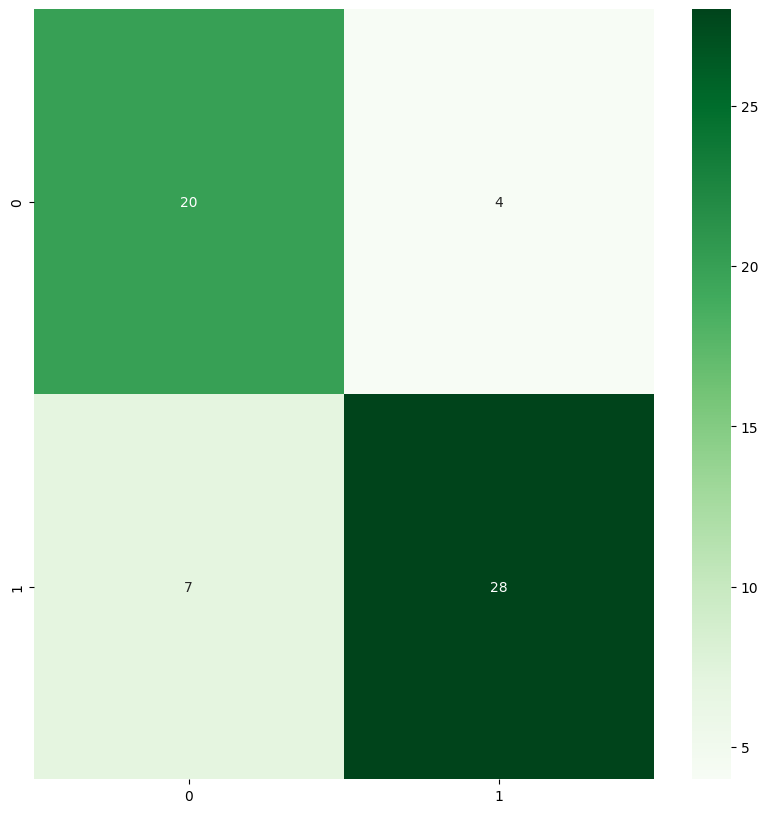

In [18]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# function to make pretty confusion matrix
def confussion_matrix(cf_matrix):
    plt.figure(figsize=(10,10))
    sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Greens')






# create the cunfusion matrix
confussion_matrix(confusion_matrix(test_y,mypred))
